## Imports

In [1]:
from collections import Counter
from math import e

import numba
import numpy as np
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from umap import UMAP
from wordcloud import WordCloud, get_single_color_func

from khan_helpers import Experiment
from khan_helpers.constants import (
    EMBS_DIR, 
    FIG_DIR, 
    DATA_DIR, 
    MODELS_DIR, 
    N_PARTICIPANTS,
    UMAP_PARAMS
)
from khan_helpers.functions import multicol_display

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

## Define some functions & classes

#### Custom distance metric for UMAP embedding

In [2]:
@numba.njit
def correlation_exp(x, y):
    x = e ** x
    y = e ** y
    mu_x = 0.0
    mu_y = 0.0
    norm_x = 0.0
    norm_y = 0.0
    dot_product = 0.0

    for i in range(x.shape[0]):
        mu_x += x[i]
        mu_y += y[i]

    mu_x /= x.shape[0]
    mu_y /= x.shape[0]

    for i in range(x.shape[0]):
        shifted_x = x[i] - mu_x
        shifted_y = y[i] - mu_y
        norm_x += shifted_x ** 2
        norm_y += shifted_y ** 2
        dot_product += shifted_x * shifted_y

    if norm_x == 0.0 and norm_y == 0.0:
        dist = 0.0
        grad = np.zeros(x.shape)
    elif dot_product == 0.0:
        dist = 1.0
        grad = np.zeros(x.shape)
    else:
        dist = 1.0 - (dot_product / np.sqrt(norm_x * norm_y))
        grad = ((x - mu_x) / norm_x - (y - mu_y) / dot_product) * dist

    return dist, grad

#### Creating and plotting wordles

In [3]:
def topn(weights_dict, n_words):
    return dict(Counter(weights_dict).most_common(n_words))

In [4]:
def get_word_weights(trajectory, topic_model):
    m = np.dot(trajectory, topic_model.components_)
    m -= m.mean(axis=0)
    m -= m.min()
    m /= m.max()
    return m

In [5]:
class SimpleGroupedColorFunc(object):
    """
    Creates a callable to be passed to WordCloud for coloring words based 
    on color_to_words mapping
    
   Parameters
   ----------
   color_to_words : dict(str: list(str))
     A dictionary that maps a color to the list of words.
   default_color : str
     Color that will be assigned to any word not contained in 
     color_to_words.values()
    """
    
    def __init__(self, color_to_words, default_color='grey'):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}
        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

In [6]:
def plot_wordle(ax, textdict, color_func, mask=None, random_state=0):
    wc = WordCloud(
        max_font_size=50, 
        collocations=False, 
        max_words=200, 
        background_color="white", 
        mask=mask, 
        width=2000, 
        height=1000,
        color_func=color_func,
        random_state=random_state,
        relative_scaling=1
    )
    wc.generate_from_frequencies(textdict)
#     img = wc.recolor(color_func=color_func, random_state=random_state)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")

## Set some parameters

In [7]:
exp = Experiment()

In [8]:
# embedding params
seed = UMAP_PARAMS['random_state']
UMAP_PARAMS['metric'] = correlation_exp
print(UMAP_PARAMS)

{'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.8, 'spread': 1.0, 'random_state': 0, 'metric': CPUDispatcher(<function correlation_exp at 0x7f56916cb4d0>)}


In [9]:
multicol_display(*UMAP_PARAMS.values(), 
                 ncols=len(UMAP_PARAMS), 
                 col_headers=UMAP_PARAMS.keys(), 
                 caption="UMAP parameters")

2,15,0.8,1.0,0,CPUDispatcher()


In [10]:
# plotting params
kmaps_fig_dir = FIG_DIR.joinpath('knowledge-maps-components')
if not kmaps_fig_dir.is_dir():
    kmaps_fig_dir.mkdir()

plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper')
cmap = 'bone'

## Create 2D embeddings

In [11]:
# fit UMAP model to all lectures & questions to embed in common space
to_reduce = exp.get_lecture_traj(('forces', 'bos'))
to_reduce.extend(list(exp.get_question_vecs(lectures=('forces', 'bos', 'general'))))

# store incidces to separate embedding data later
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in to_reduce])[:2]

# log-transform, concatenate along feature dimension
to_reduce = np.log(np.vstack(to_reduce))

In [12]:
np.random.seed(seed)
reducer = UMAP(verbose=True, **UMAP_PARAMS).fit(to_reduce)
embeddings = reducer.embedding_
forces_emb, bos_emb, questions_embs = np.vsplit(embeddings, split_inds)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False,
     metric=CPUDispatcher(<function correlation_exp at 0x7f56916cb4d0>),
     metric_kwds=None, min_dist=0.8, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Jul 20 22:55:59 2020 Finding Nearest Neighbors
Mon Jul 20 22:56:02 2020 Finished Nearest Neighbor Search
Mon Jul 20 22:56:04 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  50

In [13]:
# # save fit UMAP reducer and 2D embeddings
# np.save(MODELS_DIR.joinpath('fit_UMAP'), reducer)
# np.save(EMBS_DIR.joinpath('forces_lecture'), forces_emb)
# np.save(EMBS_DIR.joinpath('bos_lecture'), bos_emb)
# np.save(EMBS_DIR.joinpath('questions'), questions_embs)

# # load back in later
# reducer = exp.load_umap()
# forces_emb, bos_emb, questions_embs = exp.load_embeddings()

## Create a 2D grid over the embedding space

In [14]:
resolution = 100
x_min, y_min = embeddings.min(axis=0) // 1 - 3
x_max, y_max = embeddings.max(axis=0) // 1 + 3
x_step = (x_max - x_min) / resolution
y_step = (y_max - y_min) / resolution
xs = np.arange(x_min, x_max, x_step)
ys = np.arange(y_min, y_max, y_step)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])
    
vertices = xy_grid.reshape(resolution**2, 2)

## Recover topic vectors for some sample coordinates

In [15]:
# choose some locations for displaying word clouds
wordle_coords = np.array([[-10, 8], [9, -12], [12, 4], [-2, 3]])

# inverse-transform coordinates into original topic space
np.random.seed(reducer.transform_seed)
wordle_vectors = reducer.inverse_transform(wordle_coords).astype(np.float64)

# undo log-transform & normalize
wordle_vectors = np.exp(wordle_vectors)
wordle_vectors /= wordle_vectors.sum(axis=1, keepdims=True)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [16]:
# plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
# plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r--')
# plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g--')
# plt.scatter(questions_embs[:15, 0], questions_embs[:15, 1], c='r', marker='o')
# plt.scatter(questions_embs[15:30, 0], questions_embs[15:30, 1], c='g', marker='o')
# plt.scatter(questions_embs[30:, 0], questions_embs[30:, 1], c='b', marker='o')
# plt.plot(wordle_coords[:, 0], wordle_coords[:, 1], 'k*', markersize=8)
# plt.show()

## Construct knowledge maps from memory traces for embedded lectures

In [17]:
# NOTE: knowledge maps take ~2 mintues to reconstruct
maps_arr = np.empty((3, len(exp.participants), resolution, resolution), dtype=np.float64)

pbar = tqdm(total=len(exp.participants)*3, leave=False)
for qset in range(3):
    store_key = f'forces_bos_qset{qset}'
    for i, p in enumerate(exp.participants):
        # known values are knowledge traces for BOTH lectures
        maps_arr[qset, i] = p.construct_knowledge_map(exp,
                                                      lecture=('forces', 'bos'),
                                                      qset=qset,
                                                      map_grid=xy_grid,
                                                      rbf_width=50,
                                                      rbf_metric='euclidean',
                                                      store=store_key)
        pbar.update()
        
    # store average in avg participant
    exp.avg_participant.store_kmap(maps_arr[qset].mean(axis=0), store_key)
pbar.close()

In [18]:
# # save updated participant objects
# exp.save_participants(allow_overwrite=True)

In [19]:
# uniformly shift coordinates to line up with heatmap bounds for plotting
shifted_inds = np.append(split_inds, [1137, 1141])
coords = np.vstack((embeddings, wordle_coords, vertices))
coords_shifted = coords - coords.min(axis=0)
coords_shifted /= (coords_shifted.max(axis=0) / resolution)
(
    forces_shifted, 
    bos_shifted, 
    questions_shifted, 
    wordle_coords_shifted, 
    _
) = np.vsplit(coords_shifted, shifted_inds)

ff_qs_shifted = questions_shifted[:15]
bos_qs_shifted = questions_shifted[15:30]
gen_qs_shifted = questions_shifted[30:]

# make sure split happened at correct indices
assert len(questions_shifted) == len(questions_embs)
assert len(wordle_coords_shifted) == len(wordle_coords)

## Plot knowledge and learning maps

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


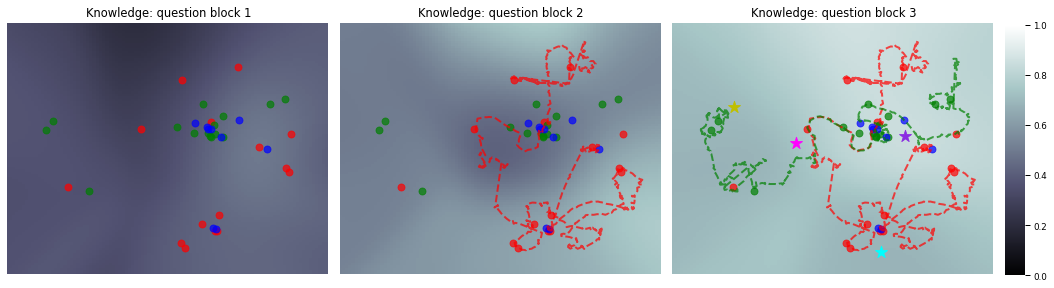

In [20]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 4)
cbar_ax = fig.add_axes([1, 0.03, .02, .87])

for i in range(3):
    kmap = exp.avg_participant.get_kmap(f'forces_bos_qset{i}')
#     low, high = kmap.min().round(1), kmap.max().round(1)
#     print(low, high)
    cbar = True if i == 2 else False
    cax = cbar_ax if i == 2 else None
    sns.heatmap(kmap, vmin=0, vmax=1, cmap=cmap, xticklabels=[], yticklabels=[], 
                cbar=cbar, ax=axes[i], cbar_ax=cax)
    
    axes[i].collections[0].remove()
    axes[i].imshow(kmap, vmin=0, vmax=1, aspect='auto', cmap=cmap)
    axes[i].scatter(ff_qs_shifted[:, 0], ff_qs_shifted[:, 1], c='r', marker='o', s=50, alpha=.7)
    axes[i].scatter(bos_qs_shifted[:, 0], bos_qs_shifted[:, 1], c='g', marker='o', s=50, alpha=.7)
    axes[i].scatter(gen_qs_shifted[:, 0], gen_qs_shifted[:, 1], c='b', marker='o', s=50, alpha=.7)
    
    if i > 0:
        axes[i].plot(forces_shifted[:, 0], forces_shifted[:, 1], 'r--', alpha=.7, linewidth=2)
    if i > 1:
        bbox = axes[i].get_position()
        axes[i].plot(bos_shifted[:, 0], bos_shifted[:, 1],'g--', alpha=.7, linewidth=2)
        for coord, color in zip(wordle_coords_shifted, ['y', 'cyan', 'blueviolet', 'fuchsia']):
            axes[i].scatter(coord[0], coord[1], c=color, marker='*', s=160)
        
    axes[i].set_title(f'Knowledge: question block {i + 1}', fontsize='large')
    # undo automatic y-axis inversion from sns.heatmap
    axes[i].invert_yaxis()
    
plt.tight_layout()
# plt.savefig(kmaps_fig_dir.joinpath('knowledge_maps.pdf'), bbox_inches='tight', dpi=1000)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


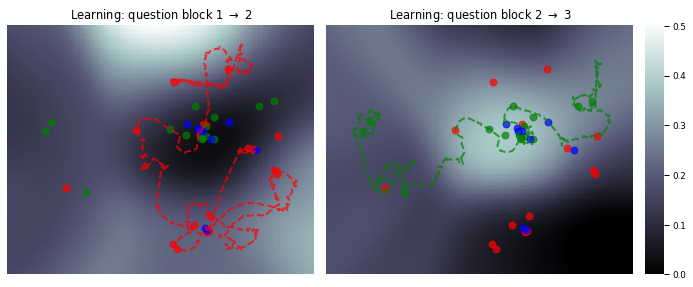

In [21]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
cbar_ax = fig.add_axes([1, 0.035, .03, .88])
for i in range(2):
    before = exp.avg_participant.get_kmap(f'forces_bos_qset{i}')
    after = exp.avg_participant.get_kmap(f'forces_bos_qset{i + 1}')
    learning_map = after - before
#     print(learning_map.min(), learning_map.max())
    cbar = True if i == 1 else False
    cax = cbar_ax if i == 1 else None
    sns.heatmap(learning_map, vmin=0, vmax=.51, cmap=cmap, xticklabels=[], 
                yticklabels=[], cbar=cbar, ax=axes[i], cbar_ax=cbar_ax)
    
    axes[i].collections[0].remove()
    axes[i].imshow(learning_map, vmin=0, vmax=.51, aspect='auto', cmap=cmap)
    axes[i].scatter(ff_qs_shifted[:, 0], ff_qs_shifted[:, 1], c='r', marker='o', s=50, alpha=.7)
    axes[i].scatter(bos_qs_shifted[:, 0], bos_qs_shifted[:, 1], c='g', marker='o', s=50, alpha=.7)
    axes[i].scatter(gen_qs_shifted[:, 0], gen_qs_shifted[:, 1], c='b', marker='o', s=50, alpha=.7)
    if i == 0:
        axes[i].plot(forces_shifted[:, 0], forces_shifted[:, 1], 'r--', alpha=.7, linewidth=2)
    else:
        axes[i].plot(bos_shifted[:, 0], bos_shifted[:, 1], 'g--', alpha=.7, linewidth=2)
    axes[i].set_title(fr'Learning: question block {i + 1} $\rightarrow$ {i + 2}', fontsize='large')
    # undo automatic y-axis inversion from sns.heatmap
    axes[i].invert_yaxis()
plt.tight_layout()
# plt.savefig(kmaps_fig_dir.joinpath('learning_maps.pdf'), bbox_inches='tight', dpi=1000)
plt.show()

#### Figure legend

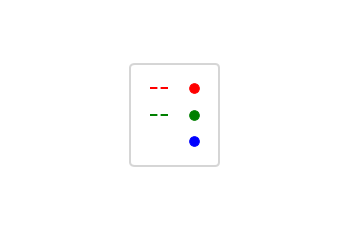

In [22]:
ft_hand = Line2D([], [], color='r', linestyle='--', linewidth=2)
bt_hand = Line2D([], [], color='g', linestyle='--', linewidth=2)
fq_hand = Line2D([], [], color='r', marker='o', linestyle='')
bq_hand = Line2D([], [], color='g', marker='o', linestyle='')
gq_hand = Line2D([], [], color='b', marker='o', linestyle='')
empty_hand = Line2D([], [], color=None, linestyle='')

handles = [ft_hand, bt_hand, empty_hand, fq_hand, bq_hand, gq_hand]
labels = [None] * 6
fig, ax = plt.subplots()
leg = fig.legend(
    handles, 
    labels, 
    loc='center', 
    ncol=2, 
    markerscale=2, 
    columnspacing=2.5, 
    labelspacing=2, 
    borderpad=2, 
    handletextpad=-.5
)
frame = leg.get_frame()
frame.set_linewidth(2)
frame.set_boxstyle('round', rounding_size=.5)
ax.axis('off')
# plt.savefig(kmaps_fig_dir.joinpath('knowledge_maps_legend.pdf'), bbox_inches='tight')
plt.show()

## Create wordles for sample points

[-10   8]


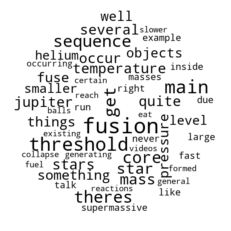

[  9 -12]


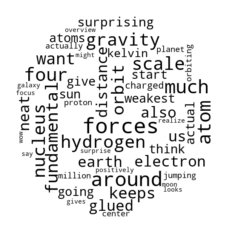

[12  4]


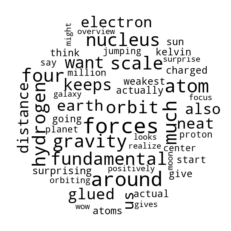

[-2  3]


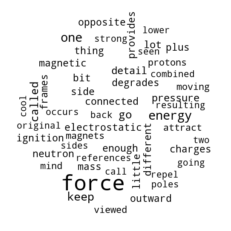

In [23]:
n_wordle_words = 50
vocabulary = exp.fit_cv.get_feature_names()
# get weights over corpus words for each topic vector
coords_wordweights = get_word_weights(wordle_vectors, exp.fit_lda)

for i, coords in enumerate(coords_wordweights):
    print(wordle_coords[i])
    weights_dict = topn(dict(zip(vocabulary, coords)), n_wordle_words)
    color_to_words = {'black': list(weights_dict)}
    color_func = SimpleGroupedColorFunc(color_to_words)
    fig, ax = plt.subplots(1)
    plot_wordle(ax, weights_dict, color_func, mask=exp.wordle_mask)
#     savepath = kmaps_fig_dir.joinpath(f'wordle_{wordle_coords[i, 0]}_{wordle_coords[i, 1]}')
#     plt.savefig(savepath, dpi=500)
    plt.show()